## Stay Days Analysis

What is the relationship between the patient data and the stay days in ICU?

In [1]:
# Import Libraries
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Pre-processing
import kardiasclean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# KMeans Cluster
from sklearn.cluster import KMeans

In [2]:
# Load Data
path2 = Path("../database/clean2")
df = pd.read_csv(path2 / "db_patient.csv")
df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,date_birth,date_procedure,rachs,stay_days,expired
0,0,0,3942,35.0,134.0,0,2001-08-22,2012-04-08,1,2,0
1,1,1,3202,18.0,117.0,0,2003-09-19,2012-11-08,1,2,0
2,2,0,3147,22.0,120.0,0,2003-11-21,2012-08-18,1,2,0
3,3,0,4005,42.0,147.0,0,2001-10-07,2012-08-25,1,2,0
4,4,0,5289,40.0,157.0,0,1997-12-22,2012-01-09,1,3,0


### Attempt to use One-to-One Linear Regression

In [3]:
# Feature and Target
rachs_stay_days_gp = df[["rachs", "stay_days"]]
rachs_stay_days_gp

,rachs,stay_days
0,1,2
1,1,2
2,1,2
3,1,2
4,1,3
...,...,...
998,3,14
999,1,2
1000,3,15
1001,4,10


Text(0, 0.5, 'Stay Days')

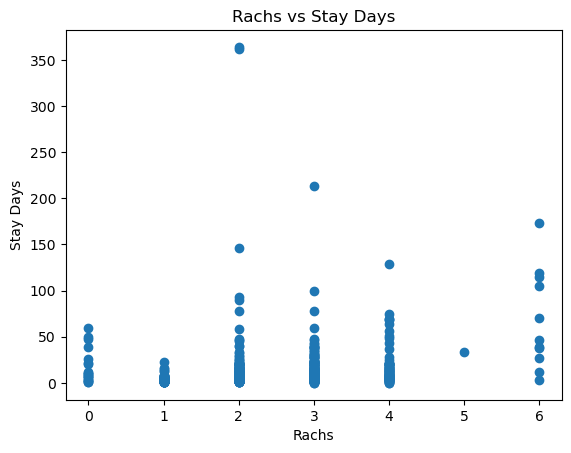

In [4]:
# Plot data
plt.scatter(df['rachs'], df['stay_days'])
plt.title(f"Rachs vs Stay Days")
plt.xlabel("Rachs")
plt.ylabel("Stay Days")

In [5]:
# Linear Regression Attempt (Fail)
X = df["rachs"].values.reshape(-1, 1)
y = df["stay_days"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X.shape, y.shape

# Create Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X)
# Evaluate Model
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
print("r-squared:", r2)
print("mean-squared error:", mse)
score = model.score(X_test, y_test)
print(f"{100*score:.2f}%")

r-squared: 0.06663137495024807
mean-squared error: 482.18769946239286
0.71%


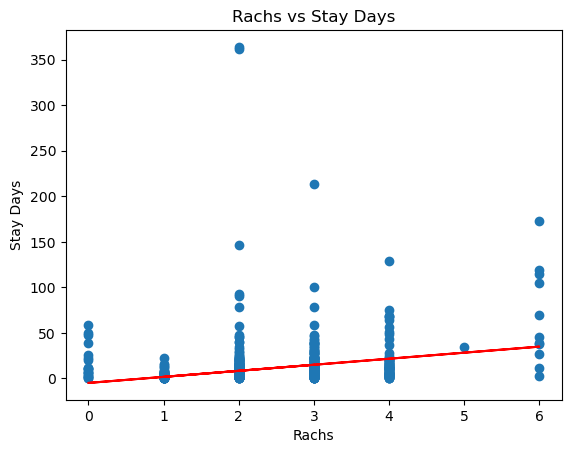

In [6]:
# Visualize Failed Linear Regression
plt.scatter(df['rachs'], df['stay_days'])
plt.title(f"Rachs vs Stay Days")
plt.xlabel("Rachs")
plt.ylabel("Stay Days")
plt.plot(X, y_pred, color='red')

### Exploratory Analysis

What are the averages of other variables by rachs score?

Note: Rachs score 0 represents records that had no Rach Score.

In [7]:
# Exploratory Group Bys
rachs_stay_days_gp = df[["rachs", "stay_days"]].groupby("rachs")
rachs = rachs_stay_days_gp.mean()

rachs_mortality = df[["rachs", "expired"]].groupby("rachs").sum()
# stay_days_rachs = pd.merge(stay_days_rachs, df["rachs"].value_counts())
rachs_count = df["rachs"].value_counts().sort_index()
rachs["patients"] = df["rachs"].value_counts().sort_values()
rachs["mortality"] = rachs_mortality
rachs["mortality_rate"] = (rachs["mortality"] / rachs["patients"]).map(lambda x: f"{100*x:,.2f}%")
# stay_days_rachs
rachs

,stay_days,patients,mortality,mortality_rate
rachs,,,,
0,17.100000,20,2,10.00%
1,2.932039,206,0,0.00%
2,8.591880,468,10,2.14%
3,13.316964,224,19,8.48%
4,18.767123,73,11,15.07%
5,34.000000,1,0,0.00%
6,67.909091,11,4,36.36%


In [8]:
# Select feature columns for clustering
columns = [
    "patient_id",
    "gender",
    "age_days", 
    "weight_kg", 
    "height_cm", 
    "cx_previous",
    "rachs",
    "stay_days",
]
df = df[columns]
df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days
0,0,0,3942,35.0,134.0,0,1,2
1,1,1,3202,18.0,117.0,0,1,2
2,2,0,3147,22.0,120.0,0,1,2
3,3,0,4005,42.0,147.0,0,1,2
4,4,0,5289,40.0,157.0,0,1,3


Include the Diagnosis Data

In [9]:
# Load additional columns: DIAGNOSIS
df2 = pd.read_csv("../database/clean3/main_diagnosis_categories.csv")
df2.dropna(inplace=True)
df2.head()

,patient_id,diagnosis_main,categories
0,0,Comunicacion interauricular secundum,CIA
1,1,Comunicacion interauricular secundum,CIA
2,2,Comunicacion interauricular secundum,CIA
3,3,Comunicacion interauricular secundum,CIA
4,4,Comunicacion interauricular secundum,CIA


In [10]:
# BIN ALL COLUMNS THAT ARE UNDER A QUANTILE THRESHOLD
THRESHOLD = 0.975
low, high = kardiasclean.perform_frequency_split_quantile(df2['categories'], THRESHOLD)
print(kardiasclean.evaluate_distribution(high, low))

df2["categories"] = kardiasclean.perform_binning_quantile(df2["categories"], THRESHOLD)
encoded_df = kardiasclean.perform_matrix_encoding(df2["categories"], df2["patient_id"], append_name=False)
encoded_df.head()

Total data (repeated): 1997
--------------------
Unique high frequency data: 9
Unique low frequency data: 336
--------------------
Total high frequency data: 1331
Total low frequency data: 666
--------------------
Percentage of high data: 66.65%
Percentage of low data: 33.35%
--------------------
Summary
--------------------
From 1997 data, 9 account for 66.65% of the total count.



,patient_id,CIA,CIV,Estenosis,PCA,Other,Coartacion Aortica,Tetralogia de Fallot,Atresia,Post-Surgical Procedure,Hipoplasia
0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,0
4,4,1,0,0,0,0,0,0,0,0,0


In [11]:
# Merge encoded data with original
merged_df = pd.merge(df, encoded_df)
merged_df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days,CIA,CIV,Estenosis,PCA,Other,Coartacion Aortica,Tetralogia de Fallot,Atresia,Post-Surgical Procedure,Hipoplasia
0,0,0,3942,35.0,134.0,0,1,2,1,0,0,0,0,0,0,0,0,0
1,1,1,3202,18.0,117.0,0,1,2,1,0,0,0,0,0,0,0,0,0
2,2,0,3147,22.0,120.0,0,1,2,1,0,0,0,0,0,0,0,0,0
3,3,0,4005,42.0,147.0,0,1,2,1,0,0,0,0,0,0,0,0,0
4,4,0,5289,40.0,157.0,0,1,3,1,0,0,0,0,0,0,0,0,0


## Principal Component Analysis

Do we have a good amount of features to make a preiction?

(Change the Binning Threshold depending on PCA evaluation)

In [12]:
y = merged_df["stay_days"]
X = merged_df.drop(columns=["stay_days"])
X_scaled = StandardScaler().fit_transform(X)
X_scaled.shape

(1003, 17)

0.9859264801935536

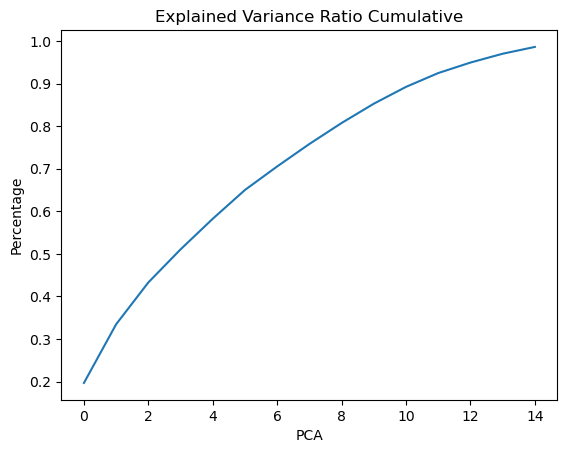

In [13]:
# Evaluate PCA
def get_explained_variance_ratio(df: pd.DataFrame, n_components: int):
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(df)
    return data, np.asarray(pca.explained_variance_ratio_)

N_COMPONENTS = 15
data, evr = get_explained_variance_ratio(X_scaled, N_COMPONENTS)
X_pca = pd.DataFrame(data, columns=[f"PC{x+1}" for x in range(N_COMPONENTS)])

plt.plot(np.cumsum(evr))
plt.title("Explained Variance Ratio Cumulative")
plt.xlabel("PCA")
plt.ylabel("Percentage")
sum(evr)

**CONCLUSION:** We are not going to use the PCA, because the cleaning was good.

## KMeans Clustering

Apply a Clustering Algorithm.

C:\Users\dani3\anaconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory leak on Windows "


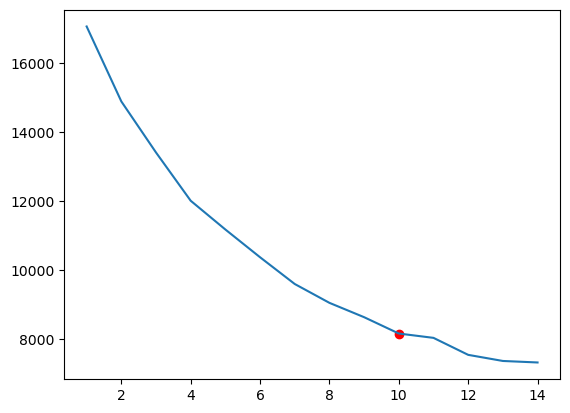

In [14]:
# Plot the Elbow curve
sse = pd.Series({k: KMeans(n_clusters=k).fit(X_scaled).inertia_ for k in range(1, 15)})
N_CLUSTERS = 10
plt.scatter(N_CLUSTERS, sse[N_CLUSTERS], color="red")
plt.plot(sse.index, sse.values)

In [15]:
# Create Clusters
model = KMeans(n_clusters=N_CLUSTERS, random_state=1).fit(X_scaled)
clusters = pd.Series(model.predict(X_scaled))
print("Patients per Cluster")
clusters.value_counts().sort_index()

Patients per Cluster


0     64
1    131
2     58
3     70
4     95
5     77
6    182
7    134
8     46
9    146
dtype: int64

In [16]:
# Merge with ORIGINAL DATA
clustered_df = merged_df.copy(deep=True)
clustered_df["cluster"] = clusters
clustered_df.head()
clustered_df.to_csv("../visualization/csv/map_diagnosis_main.csv", index=False)

Text(0, 0.5, 'Average Stay Days')

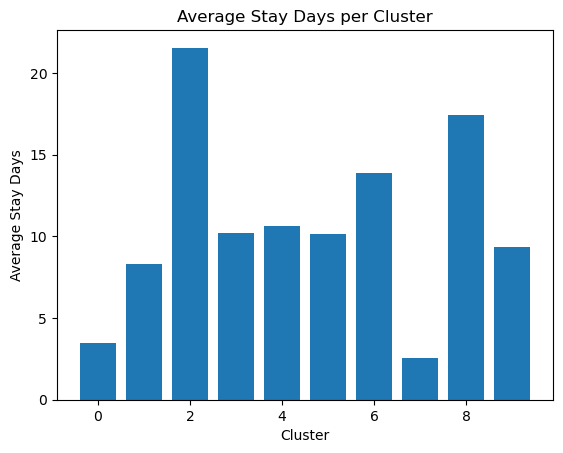

In [17]:
# Look at clusters
plot_data = clustered_df.groupby("cluster").mean()["stay_days"]
plot_x = plot_data.index
plot_y = plot_data.values
plt.bar(plot_x, plot_y)
plt.title("Average Stay Days per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Stay Days")

In [18]:
# Create a Table of mean values per cluster
cluster_mean_df = pd.DataFrame()
target_names = ["stay_days", "rachs", "cx_previous", "age_days"]

# Process each cluster's data
for i in range(N_CLUSTERS):
    c_df = clustered_df[clustered_df["cluster"] == i]
    targets = [c_df[t].mean() for t in target_names]
    cluster_mean_df[f"Cluster {i+1}"] = [c_df.count()[0], *targets]

# Rename Index
cluster_mean_df.index = ["n_patients", *target_names]
# Transpose and Sort Data
sort_by = "stay_days"
cluster_mean_df = cluster_mean_df.transpose().sort_values(by=sort_by)
print("Table of Cluster x Mean Values")
cluster_mean_df

Table of Cluster x Mean Values


,n_patients,stay_days,rachs,cx_previous,age_days
Cluster 8,134.0,2.582090,1.037313,0.007463,2209.835821
Cluster 1,64.0,3.468750,1.703125,0.140625,5221.500000
Cluster 2,131.0,8.320611,2.045802,0.007634,1112.000000
Cluster 10,146.0,9.328767,1.849315,0.027397,832.095890
Cluster 6,77.0,10.168831,2.376623,0.077922,1533.324675
Cluster 4,70.0,10.214286,2.585714,1.585714,2059.657143
Cluster 5,95.0,10.642105,2.105263,0.084211,948.157895
Cluster 7,182.0,13.857143,2.571429,0.126374,602.983516
Cluster 9,46.0,17.413043,2.586957,0.434783,534.978261
Cluster 3,58.0,21.534483,4.137931,0.051724,621.568966


In [19]:
# Getting More stats per Column, spread in different tables
target_stats = ["mean", "std", "min", "max"]
for i in range(N_CLUSTERS):
    print("CLUSTER:", i)
    d = clustered_df[clustered_df["cluster"] == i]
    print(d[target_names].describe().loc[target_stats])

CLUSTER: 0
      stay_days     rachs  cx_previous      age_days
mean   3.468750  1.703125     0.140625   5221.500000
std    3.265834  0.770069     0.431578   2197.913838
min    0.000000  0.000000     0.000000   2440.000000
max   22.000000  3.000000     2.000000  16378.000000
CLUSTER: 1
       stay_days     rachs  cx_previous     age_days
mean    8.320611  2.045802     0.007634  1112.000000
std    34.030590  0.347797     0.087370   898.174713
min     1.000000  0.000000     0.000000    62.000000
max   364.000000  4.000000     1.000000  3869.000000
CLUSTER: 2
       stay_days     rachs  cx_previous     age_days
mean   21.534483  4.137931     0.051724   621.568966
std    32.743134  0.944945     0.291542  1259.488452
min     1.000000  2.000000     0.000000     1.000000
max   173.000000  6.000000     2.000000  5295.000000
CLUSTER: 3
      stay_days     rachs  cx_previous     age_days
mean  10.214286  2.585714     1.585714  2059.657143
std   10.323595  0.985296     0.751672  1156.694815
min  

Text(0.5, 1.0, 'Clusters Stay Days vs Rachs')

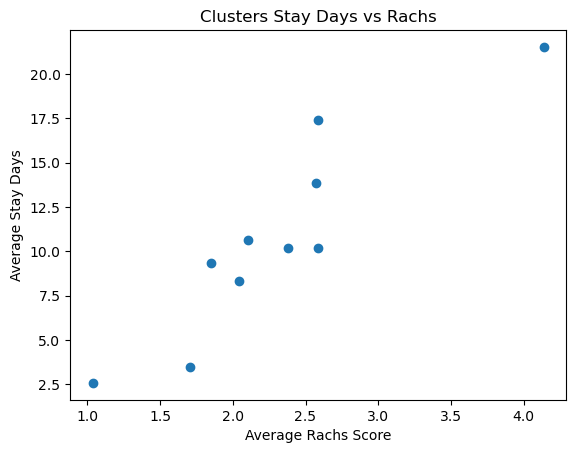

In [20]:
# Visualize stay days and rachs by cluster
plt.scatter(cluster_mean_df['rachs'], cluster_mean_df['stay_days'])
plt.xlabel("Average Rachs Score")
plt.ylabel("Average Stay Days")
plt.title("Clusters Stay Days vs Rachs")

In [21]:
# Format Results so they look better (They become strings)
formated_df = cluster_mean_df.applymap(lambda x: f"{x:.2f}")
formated_df.to_csv("../visualization/csv/clusters_diagnosis_main.csv", index=False)

## Linear Regression

Apply Linear Regression on Clusters.

In [22]:
# Select Feature and Target
X = cluster_mean_df["rachs"].values.reshape(-1, 1)
y = cluster_mean_df["stay_days"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X.shape, y.shape

((10, 1), (10, 1))

In [23]:
# Train Model
model = LinearRegression()
model.fit(X_train, y_train)
model.coef_

array([[7.64886862]])

In [24]:
# Predict and Evaluate Model
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
print("r-squared:", r2)
print("mean-squared error:", mse)
score = model.score(X_test, y_test)
print(score)

r-squared: 0.8073998973212863
mean-squared error: 5.751906712029428
0.8507812305723801


Text(0, 0.5, 'Average Stay Days')

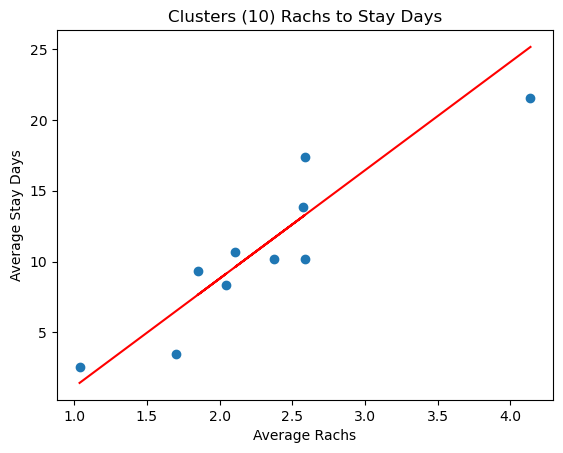

In [25]:
# Visualize Linear Regression on Clusters
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.title(f"Clusters ({N_CLUSTERS}) Rachs to Stay Days")
plt.xlabel("Average Rachs")
plt.ylabel("Average Stay Days")